In [1]:
import pickle as pk
import os
# pandas not currently installed in LLM env
# import pandas as pd
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import nltk

In [13]:
# TODO :: type annotations

def plot_top_words(model, feature_names, n_top_words, title):
    # 2x5 subplots, flatten axes
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()

    # topics are stored in model.components_
    for topic_idx, topic in enumerate(model.components_):
        # take the n_top_words; argsort implied as ascending
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        # horizontal bar (barh) plot
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    fig.savefig(title + ".png")

In [4]:
tmp = []
for i in range(1, 168):
    with open(f"2020_Fship/page_{i}.pkl", "rb") as f:
        tmp += pk.load(f)
        f.close()

In [8]:
def clean_lst(txtlist):
    ret = []
    for i, txt in enumerate(txtlist):
        if i == 0:
            ret.append(("Title", txt))
        if i == 1:
            s = txt.find("I. INCIDENT BRIEF")
            txt0 = txt[:s]
            txt1 = txt[s:]
            ret.append(("Investigation Activity Report", txt0))
            ret.append(("Incident Brief", txt1))
        elif i == 2:
            ret.append(("Incident Summary", txt))
        elif i == 3:
            ret.append(("Summary Table", txt))
        elif i == 4:
            ret.append(("Actions", txt))
        elif i == 5:
            ret.append(("Findings", txt))
        elif i == 6:
            ret.append(("Recommendations", txt))
    return ret

In [9]:
long = []
wide = {"Title" : [],
        "Investigation Activity Report" : [],
        "Incident Brief" : [],
        "Incident Summary" : [],
        "Summary Table" : [],
        "Actions" : [],
        "Findings" : [],
        "Recommendations" : []}
for fname in os.listdir("2020_Fship"):
    with open(f"2020_Fship/{fname}", "rb") as f:
        data = pk.load(f)
    pg = []
    for i, d in enumerate(data):
        pg.append("\n".join(d))
        k = i%5+1 if i > 5 else i
        [ wide[x[0]].append(x[1]) for x in clean_lst(d) ]

    long += pg

In [10]:
briefs = wide["Incident Brief"]

# 1-gram analysis

In [11]:
tfid_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=100, stop_words="english")
tfid = tfid_vectorizer.fit_transform(briefs)

tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, stop_words="english", max_features=100
)
tf = tf_vectorizer.fit_transform(briefs)

/usr/local/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:2239: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


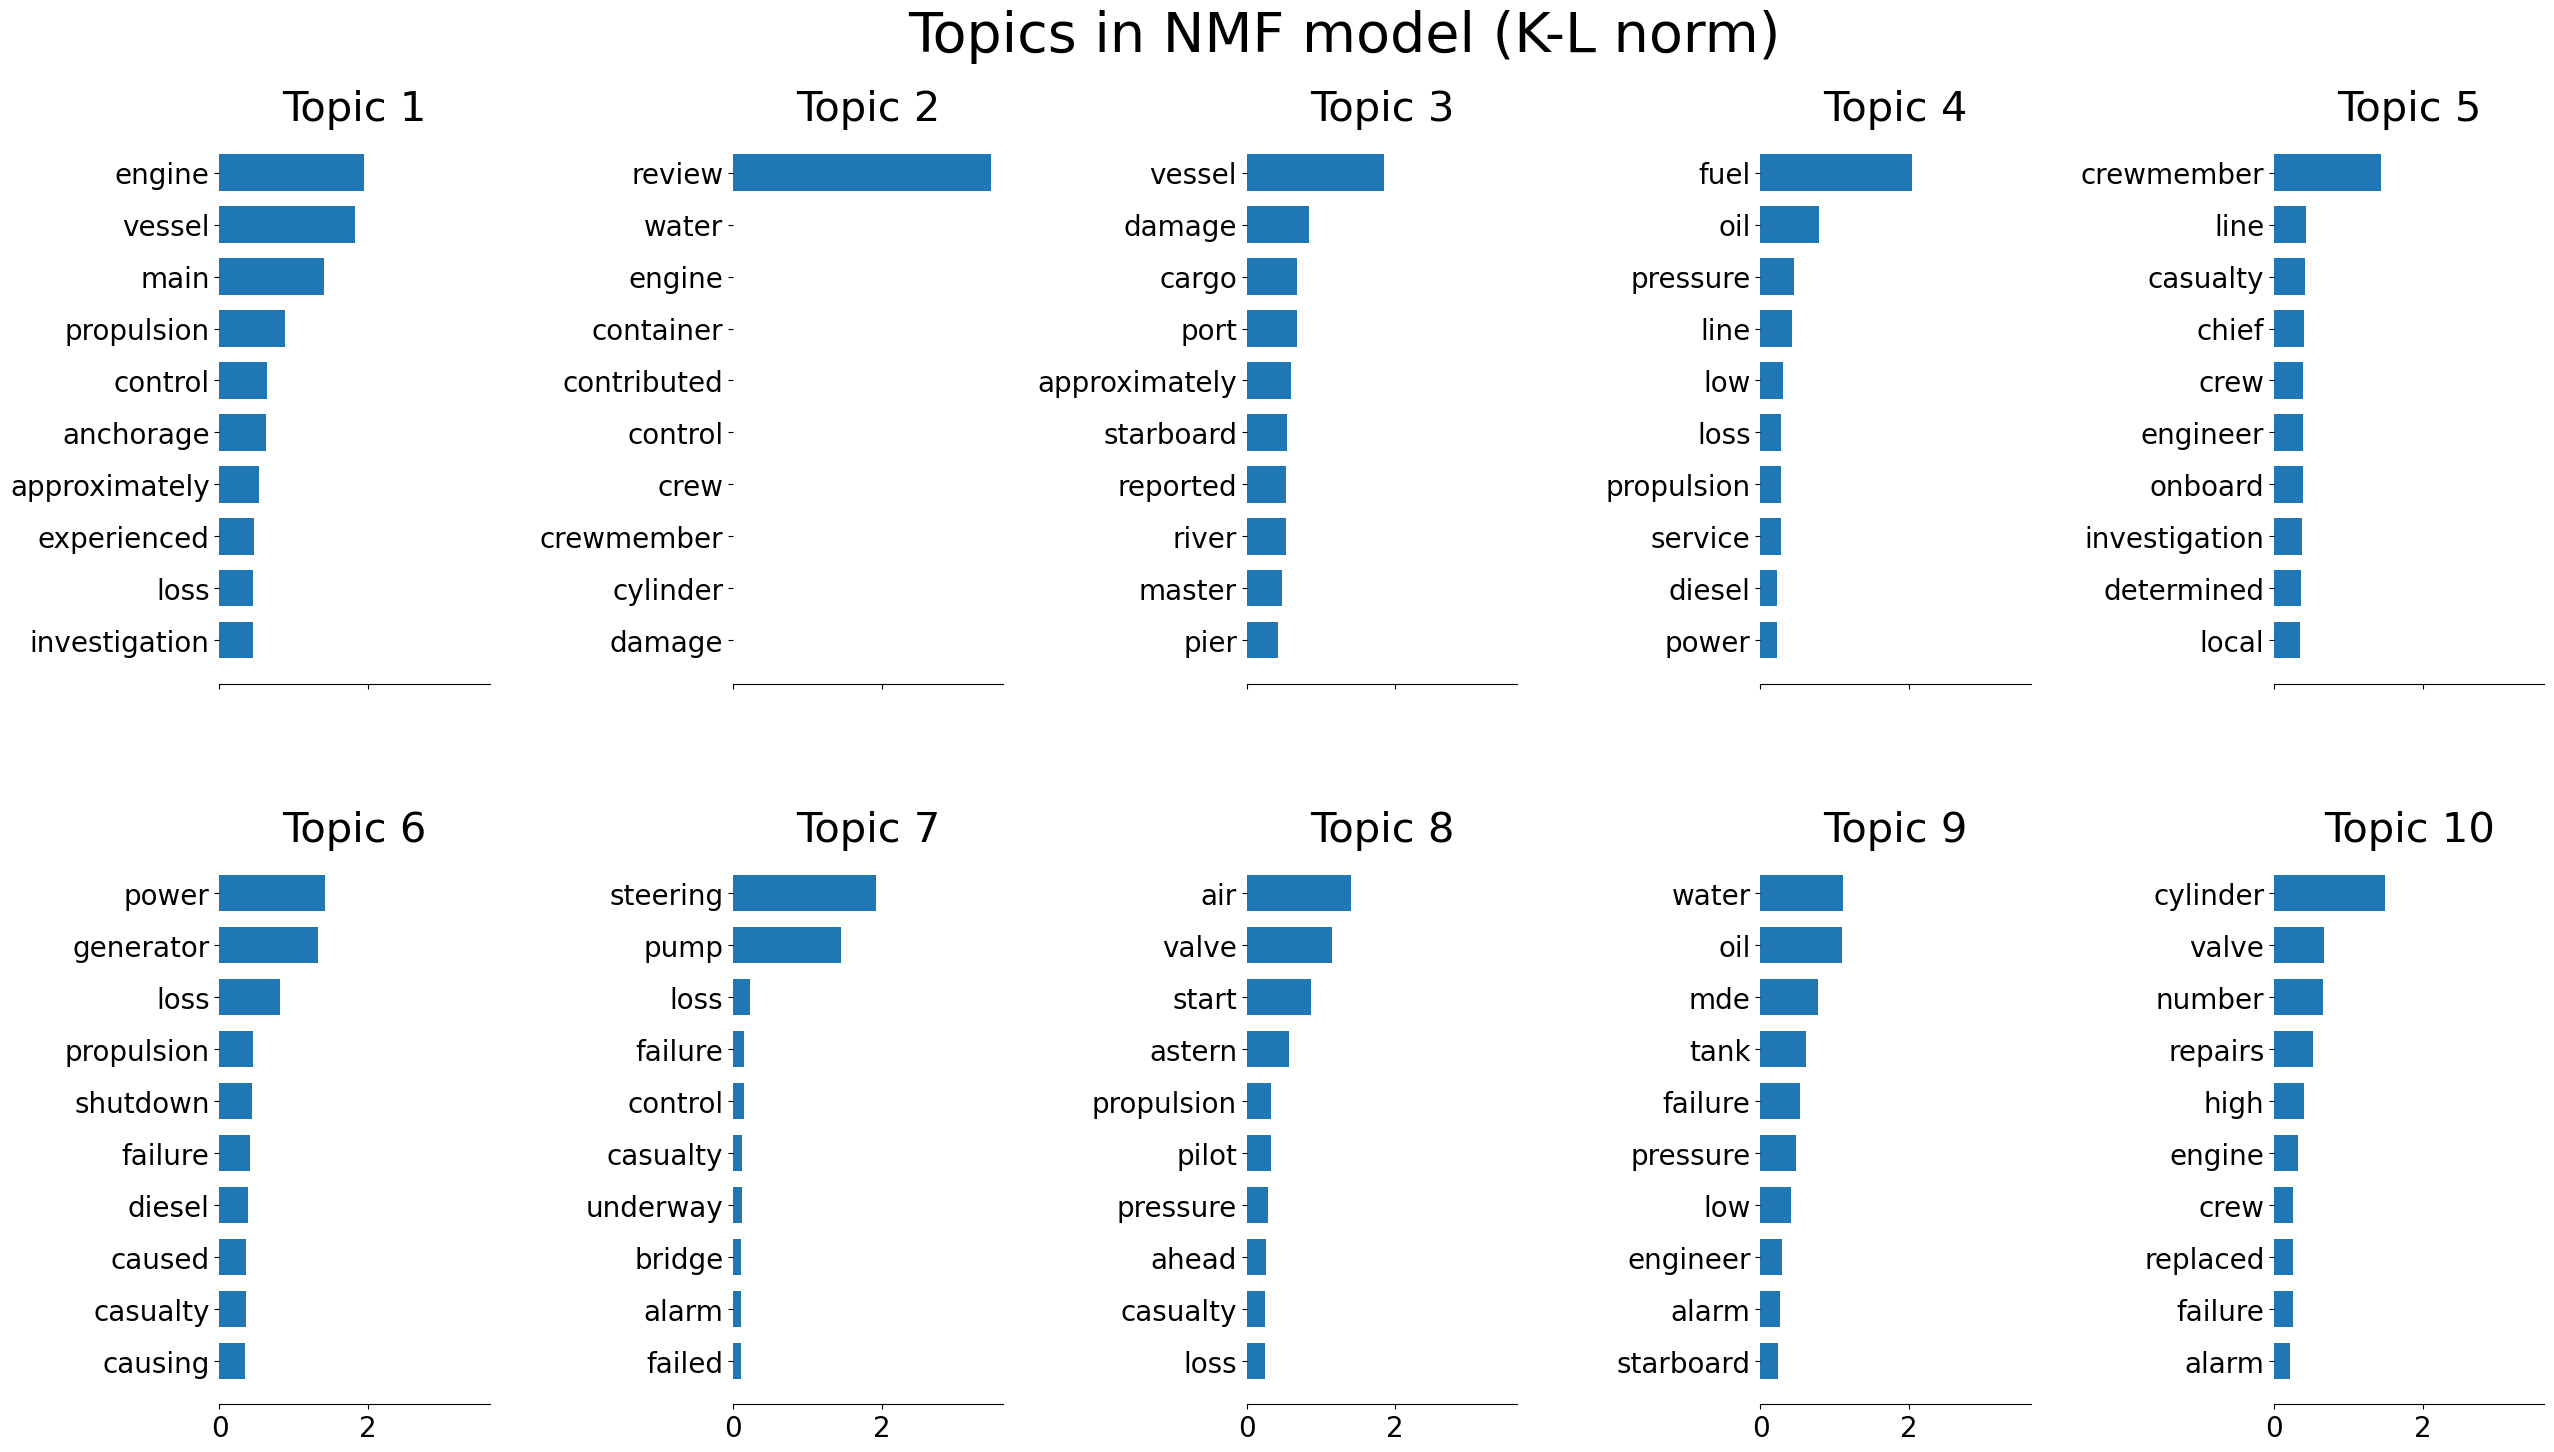

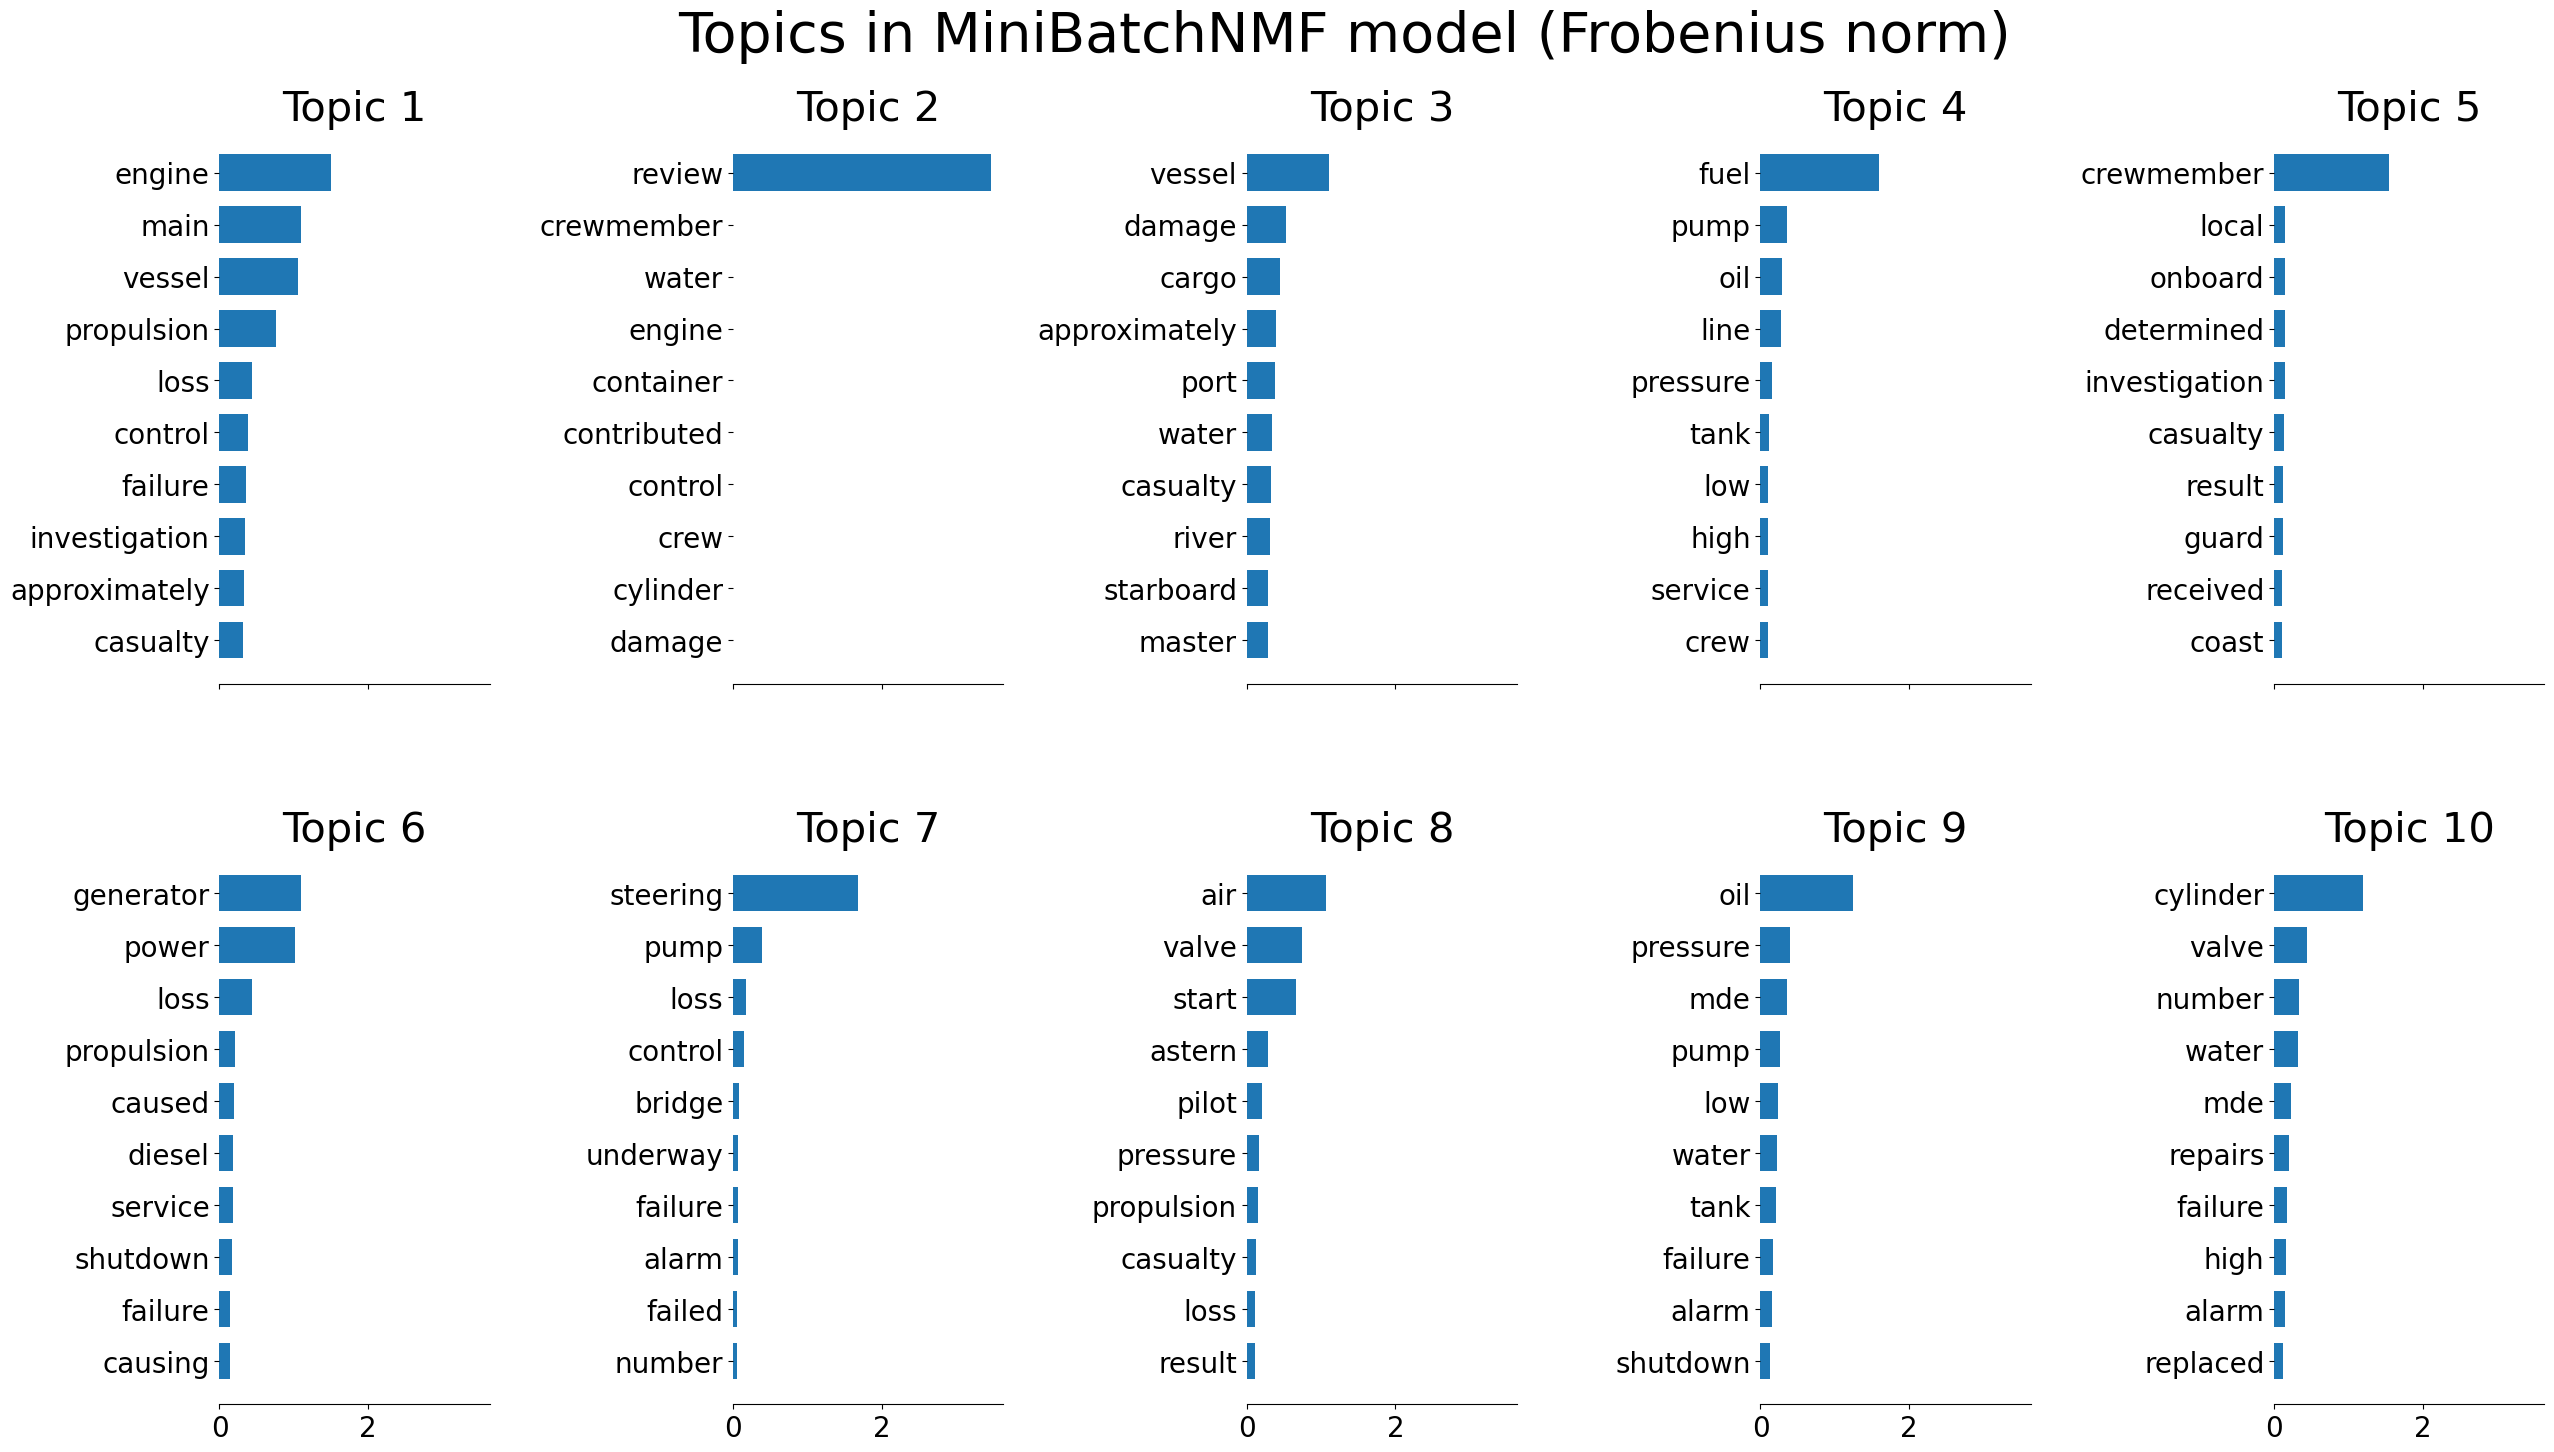

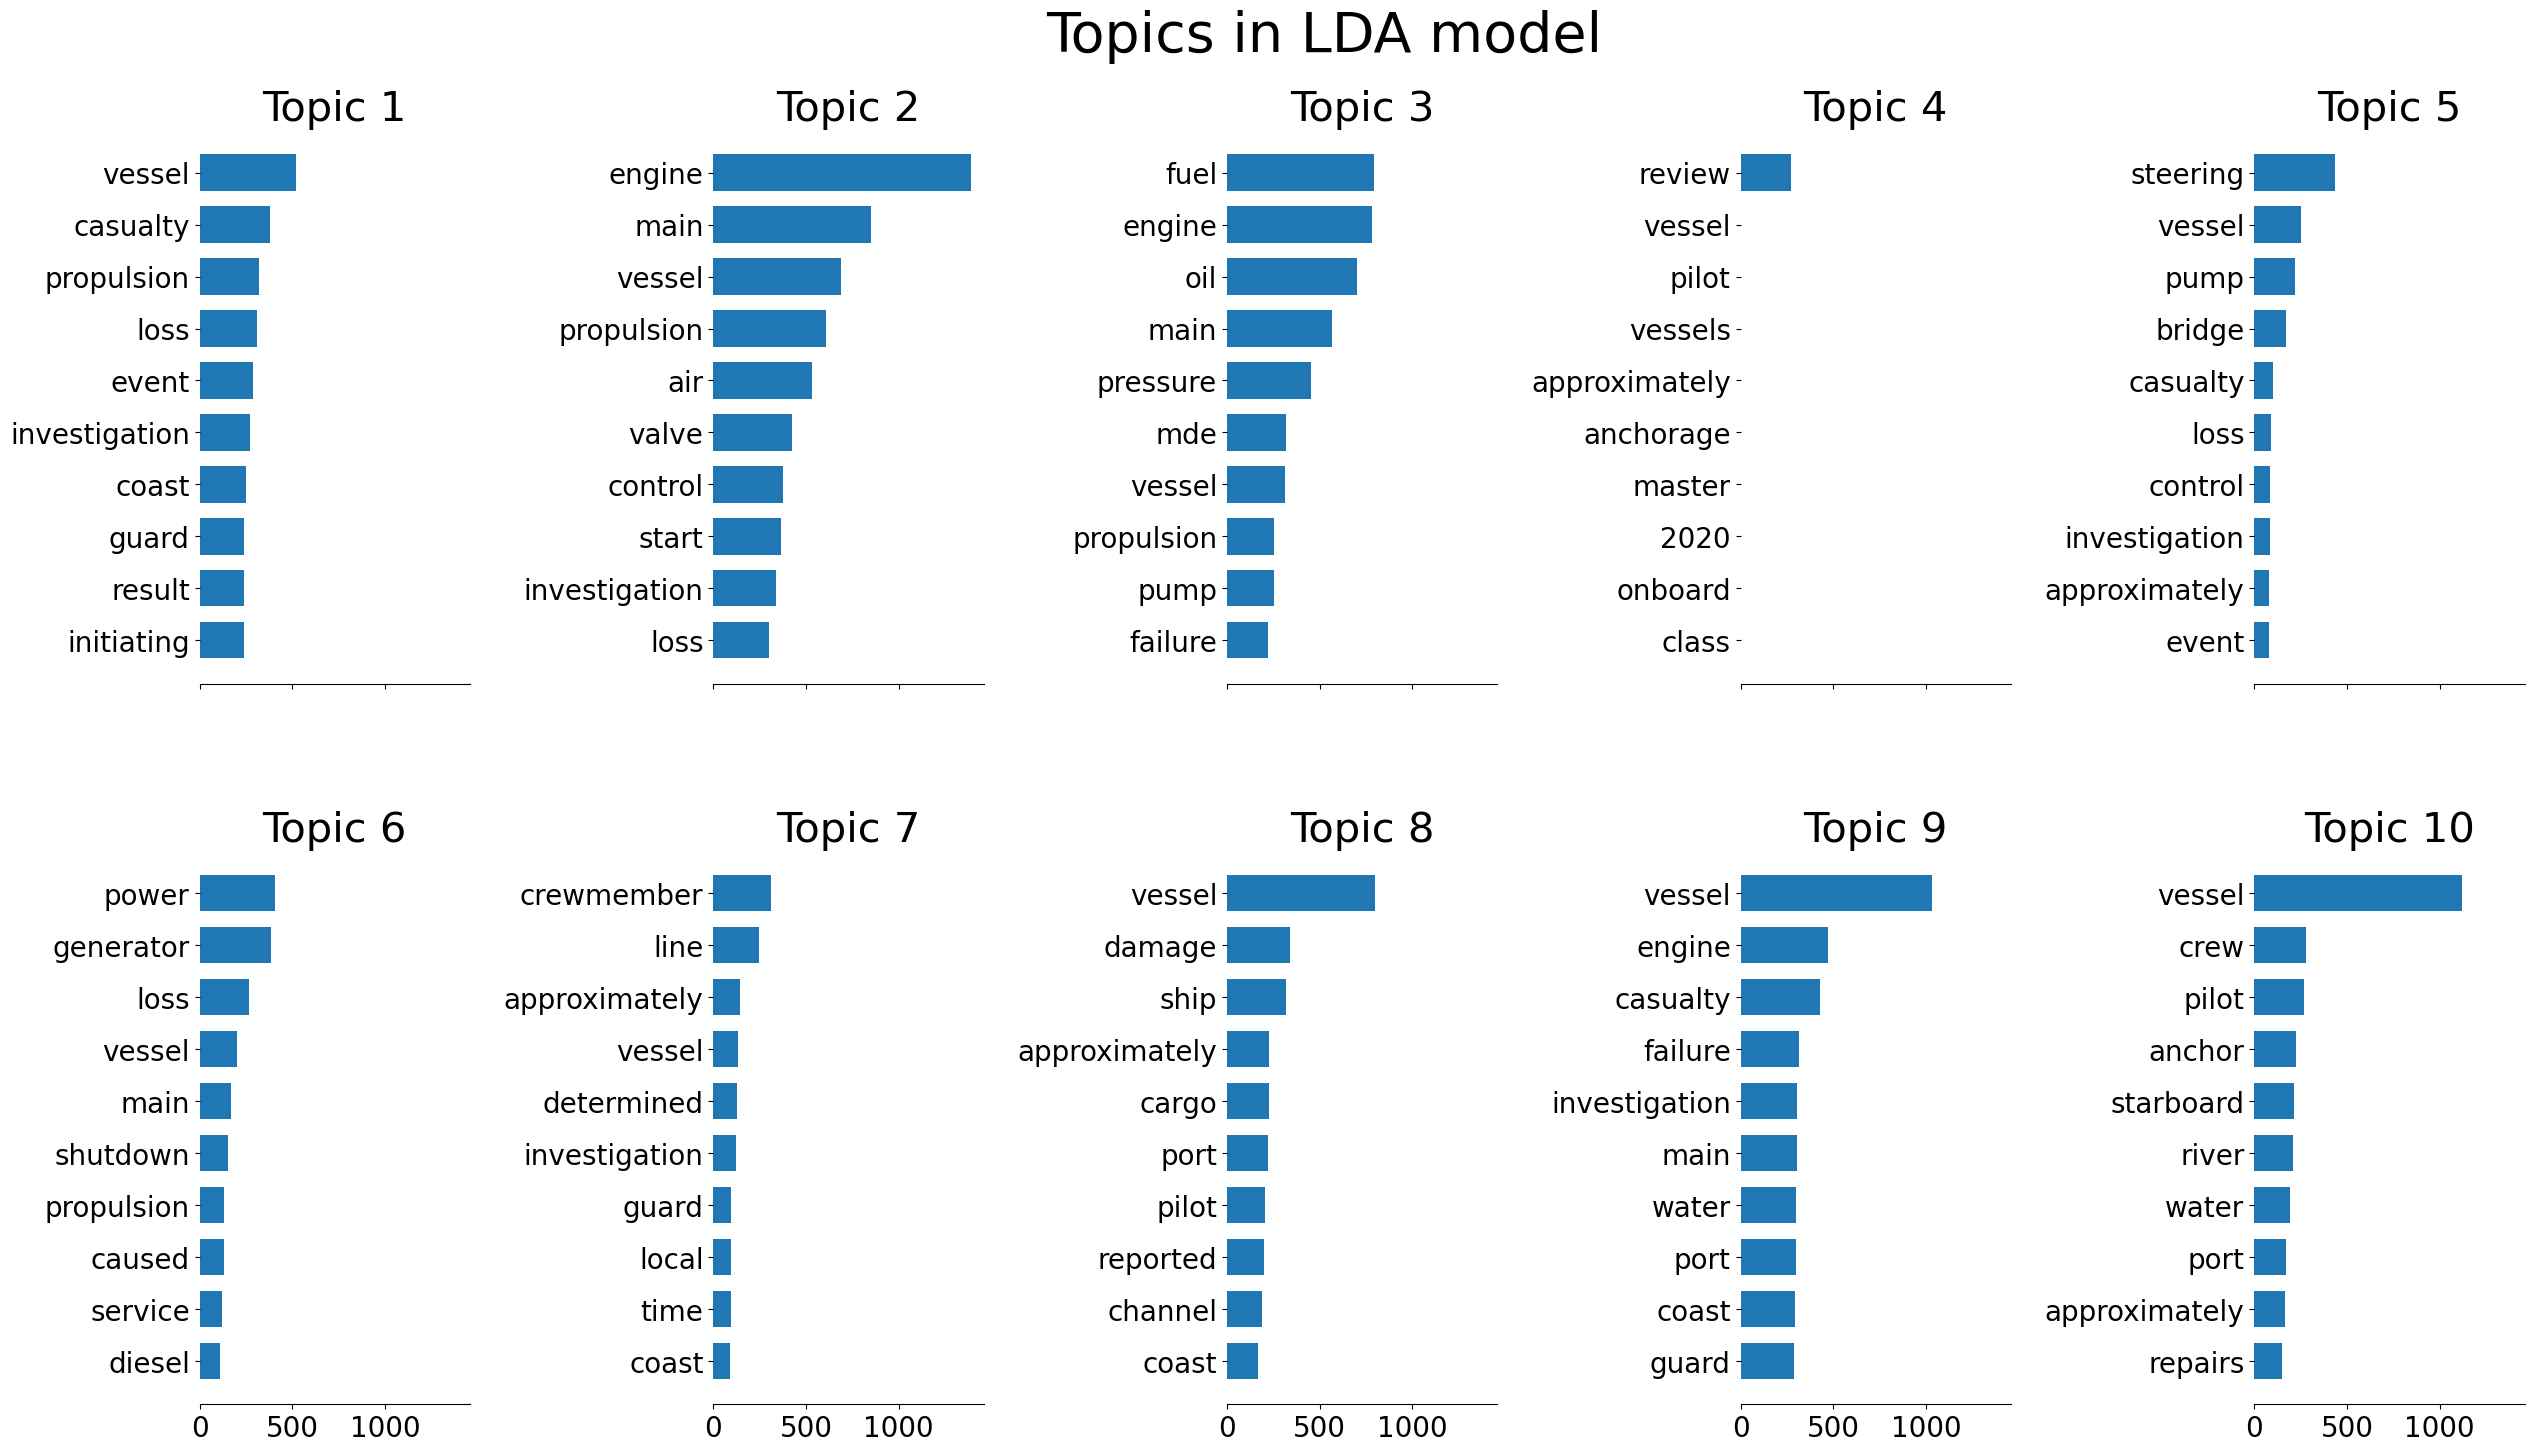

In [14]:
nmf = NMF(n_components=10,
          random_state=1,
          alpha_H=0.00005,
          alpha_W=0.00005, 
          l1_ratio=.5, 
          beta_loss="kullback-leibler",
          solver="mu",
          init="nndsvd").fit(tfid)

tfidf_feature_names = tfid_vectorizer.get_feature_names_out()
plot_top_words(nmf, tfidf_feature_names, 10, "Topics in NMF model (K-L norm)")

mbnmf = MiniBatchNMF(n_components=10, 
                     random_state=1, 
                     alpha_H=0.00005,
                     alpha_W=0.00005,
                     beta_loss="frobenius", 
                     l1_ratio=.5, 
                     init="nndsvd").fit(tfid)

tfidf_feature_names = tfid_vectorizer.get_feature_names_out()
plot_top_words(mbnmf, tfidf_feature_names, 10, "Topics in MiniBatchNMF model (Frobenius norm)")

lda = LatentDirichletAllocation(n_components=10,
                                max_iter=5,
                                learning_method="online",
                                learning_offset=50.,
                                random_state=0).fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, 10, "Topics in LDA model")

# 2-gram analysis

In [15]:
tf_vectorizer = CountVectorizer(ngram_range=(2, 2), max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(briefs)

tfid_vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_df=0.95, min_df=2, stop_words='english')
tfid = tfid_vectorizer.fit_transform(briefs)


In [16]:
nmf.components_[0].argsort()[-10:]

array([51, 54, 38, 10,  9, 28, 71, 56, 97, 35])

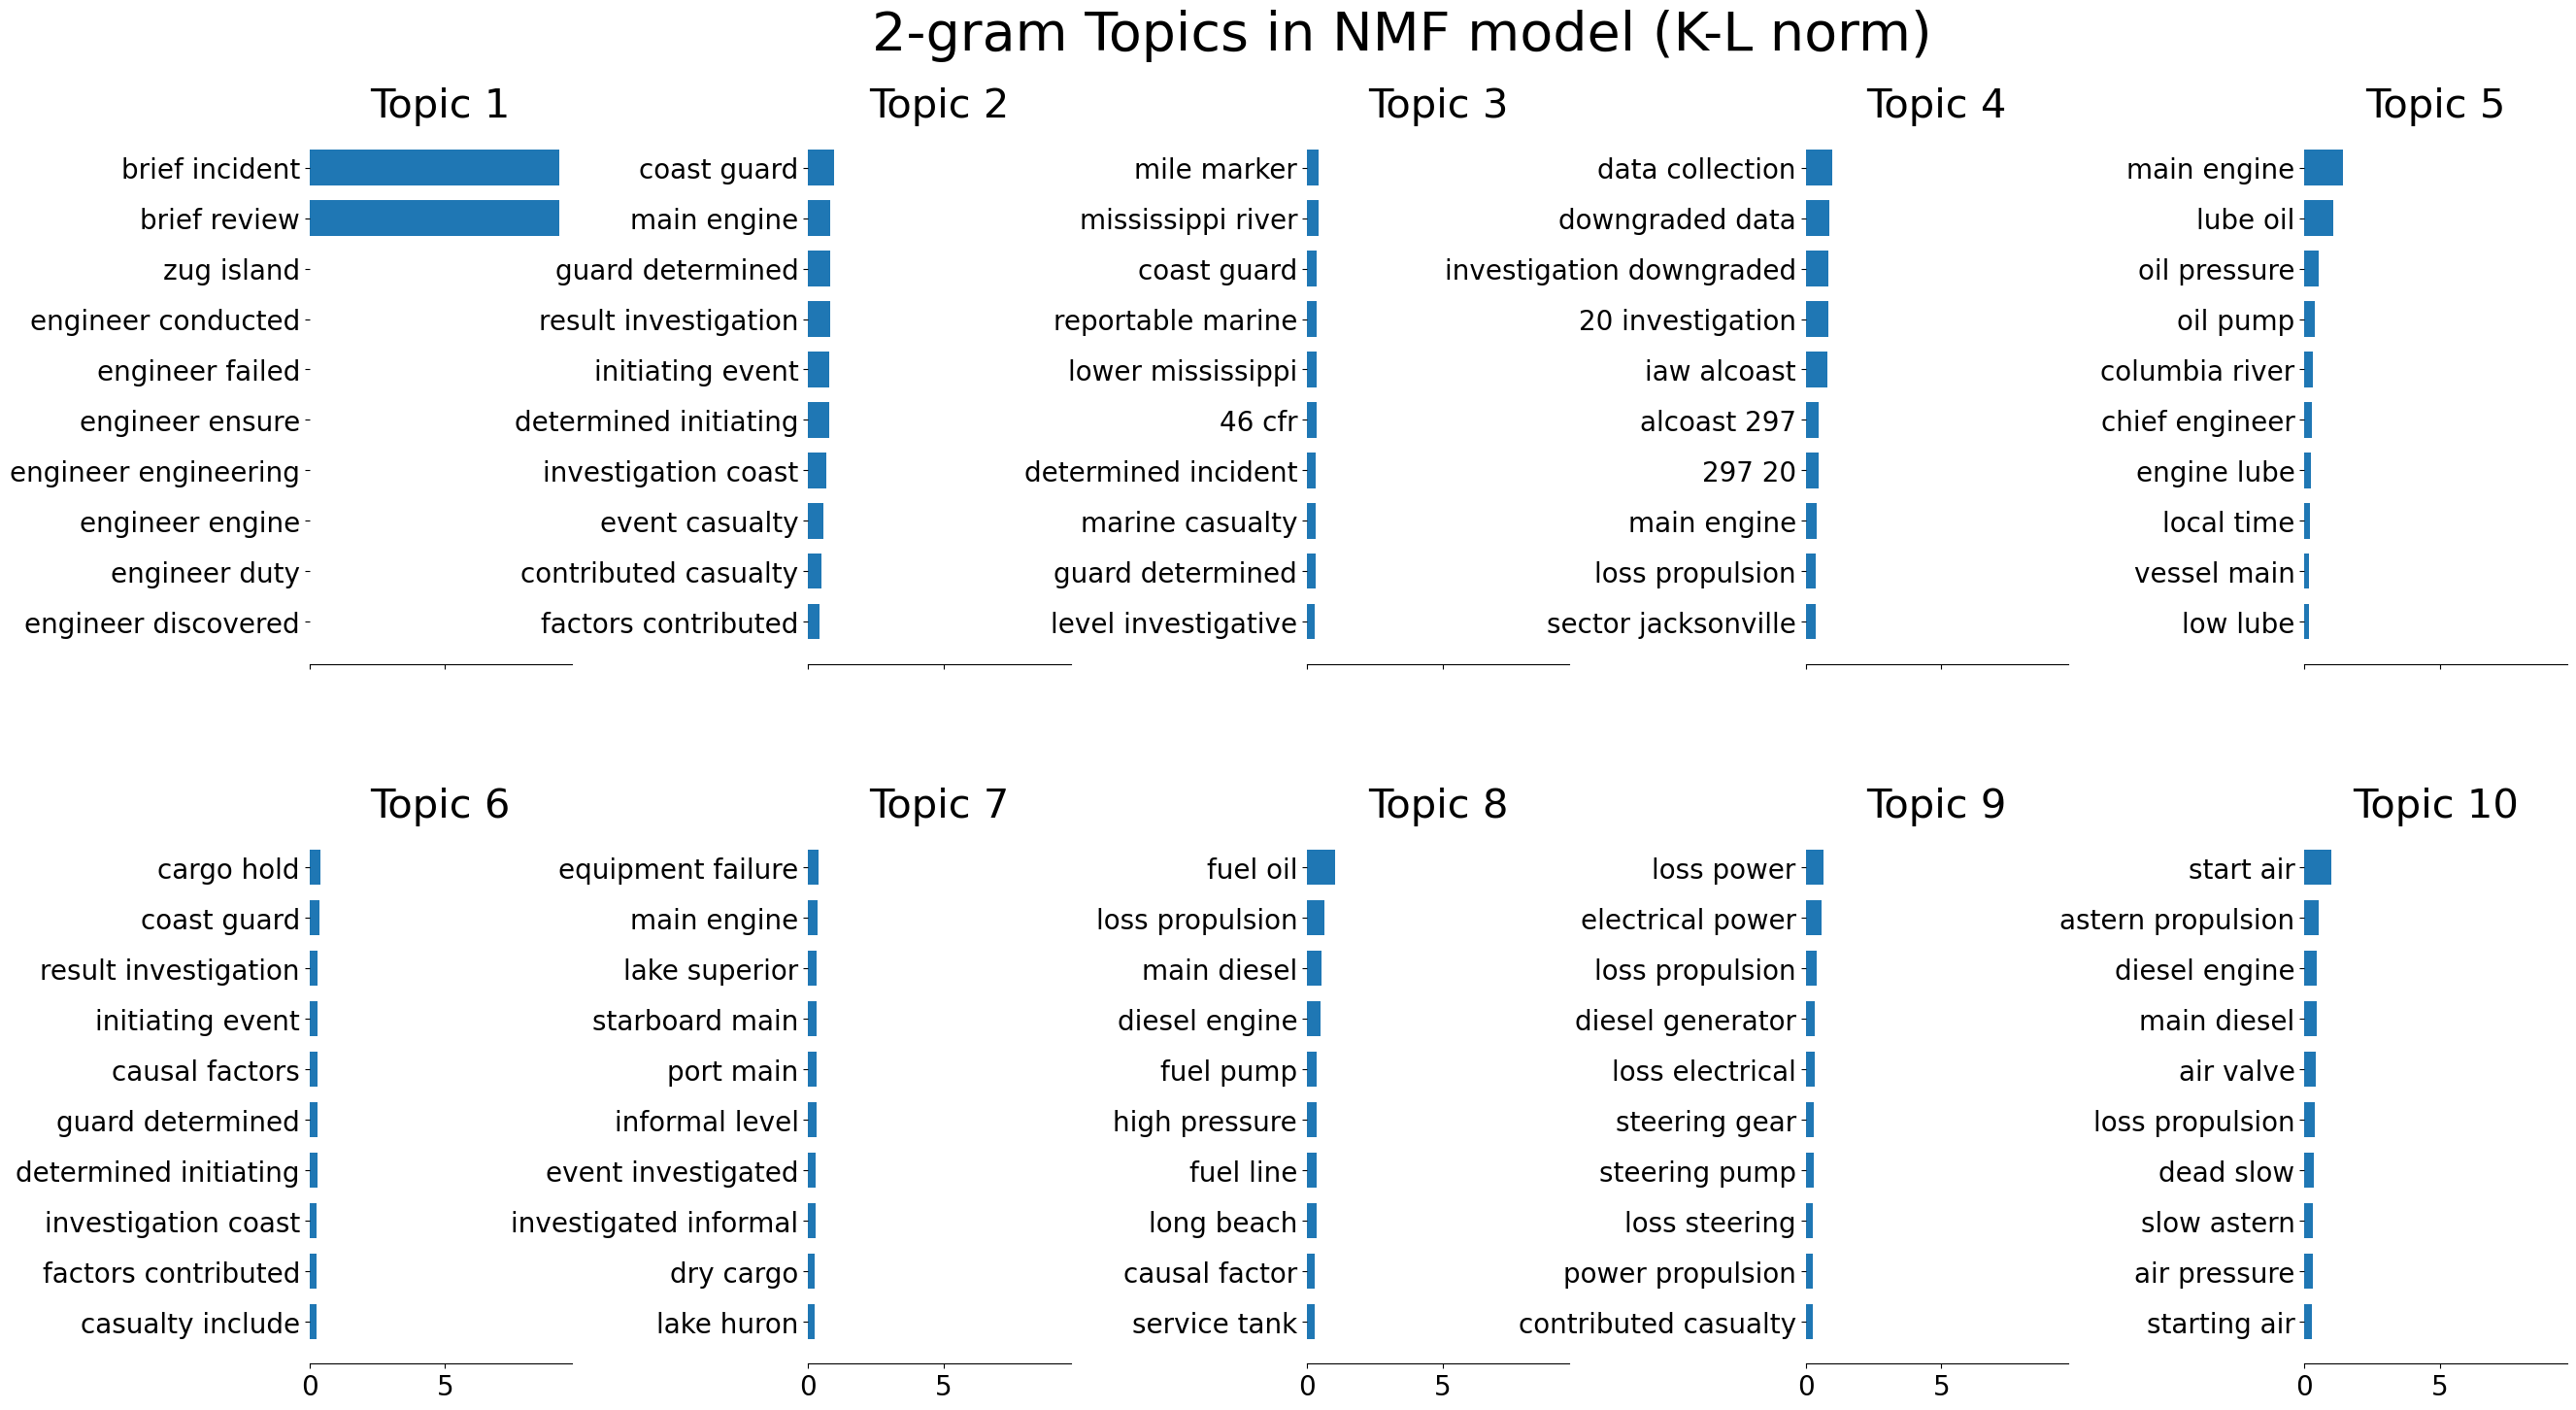

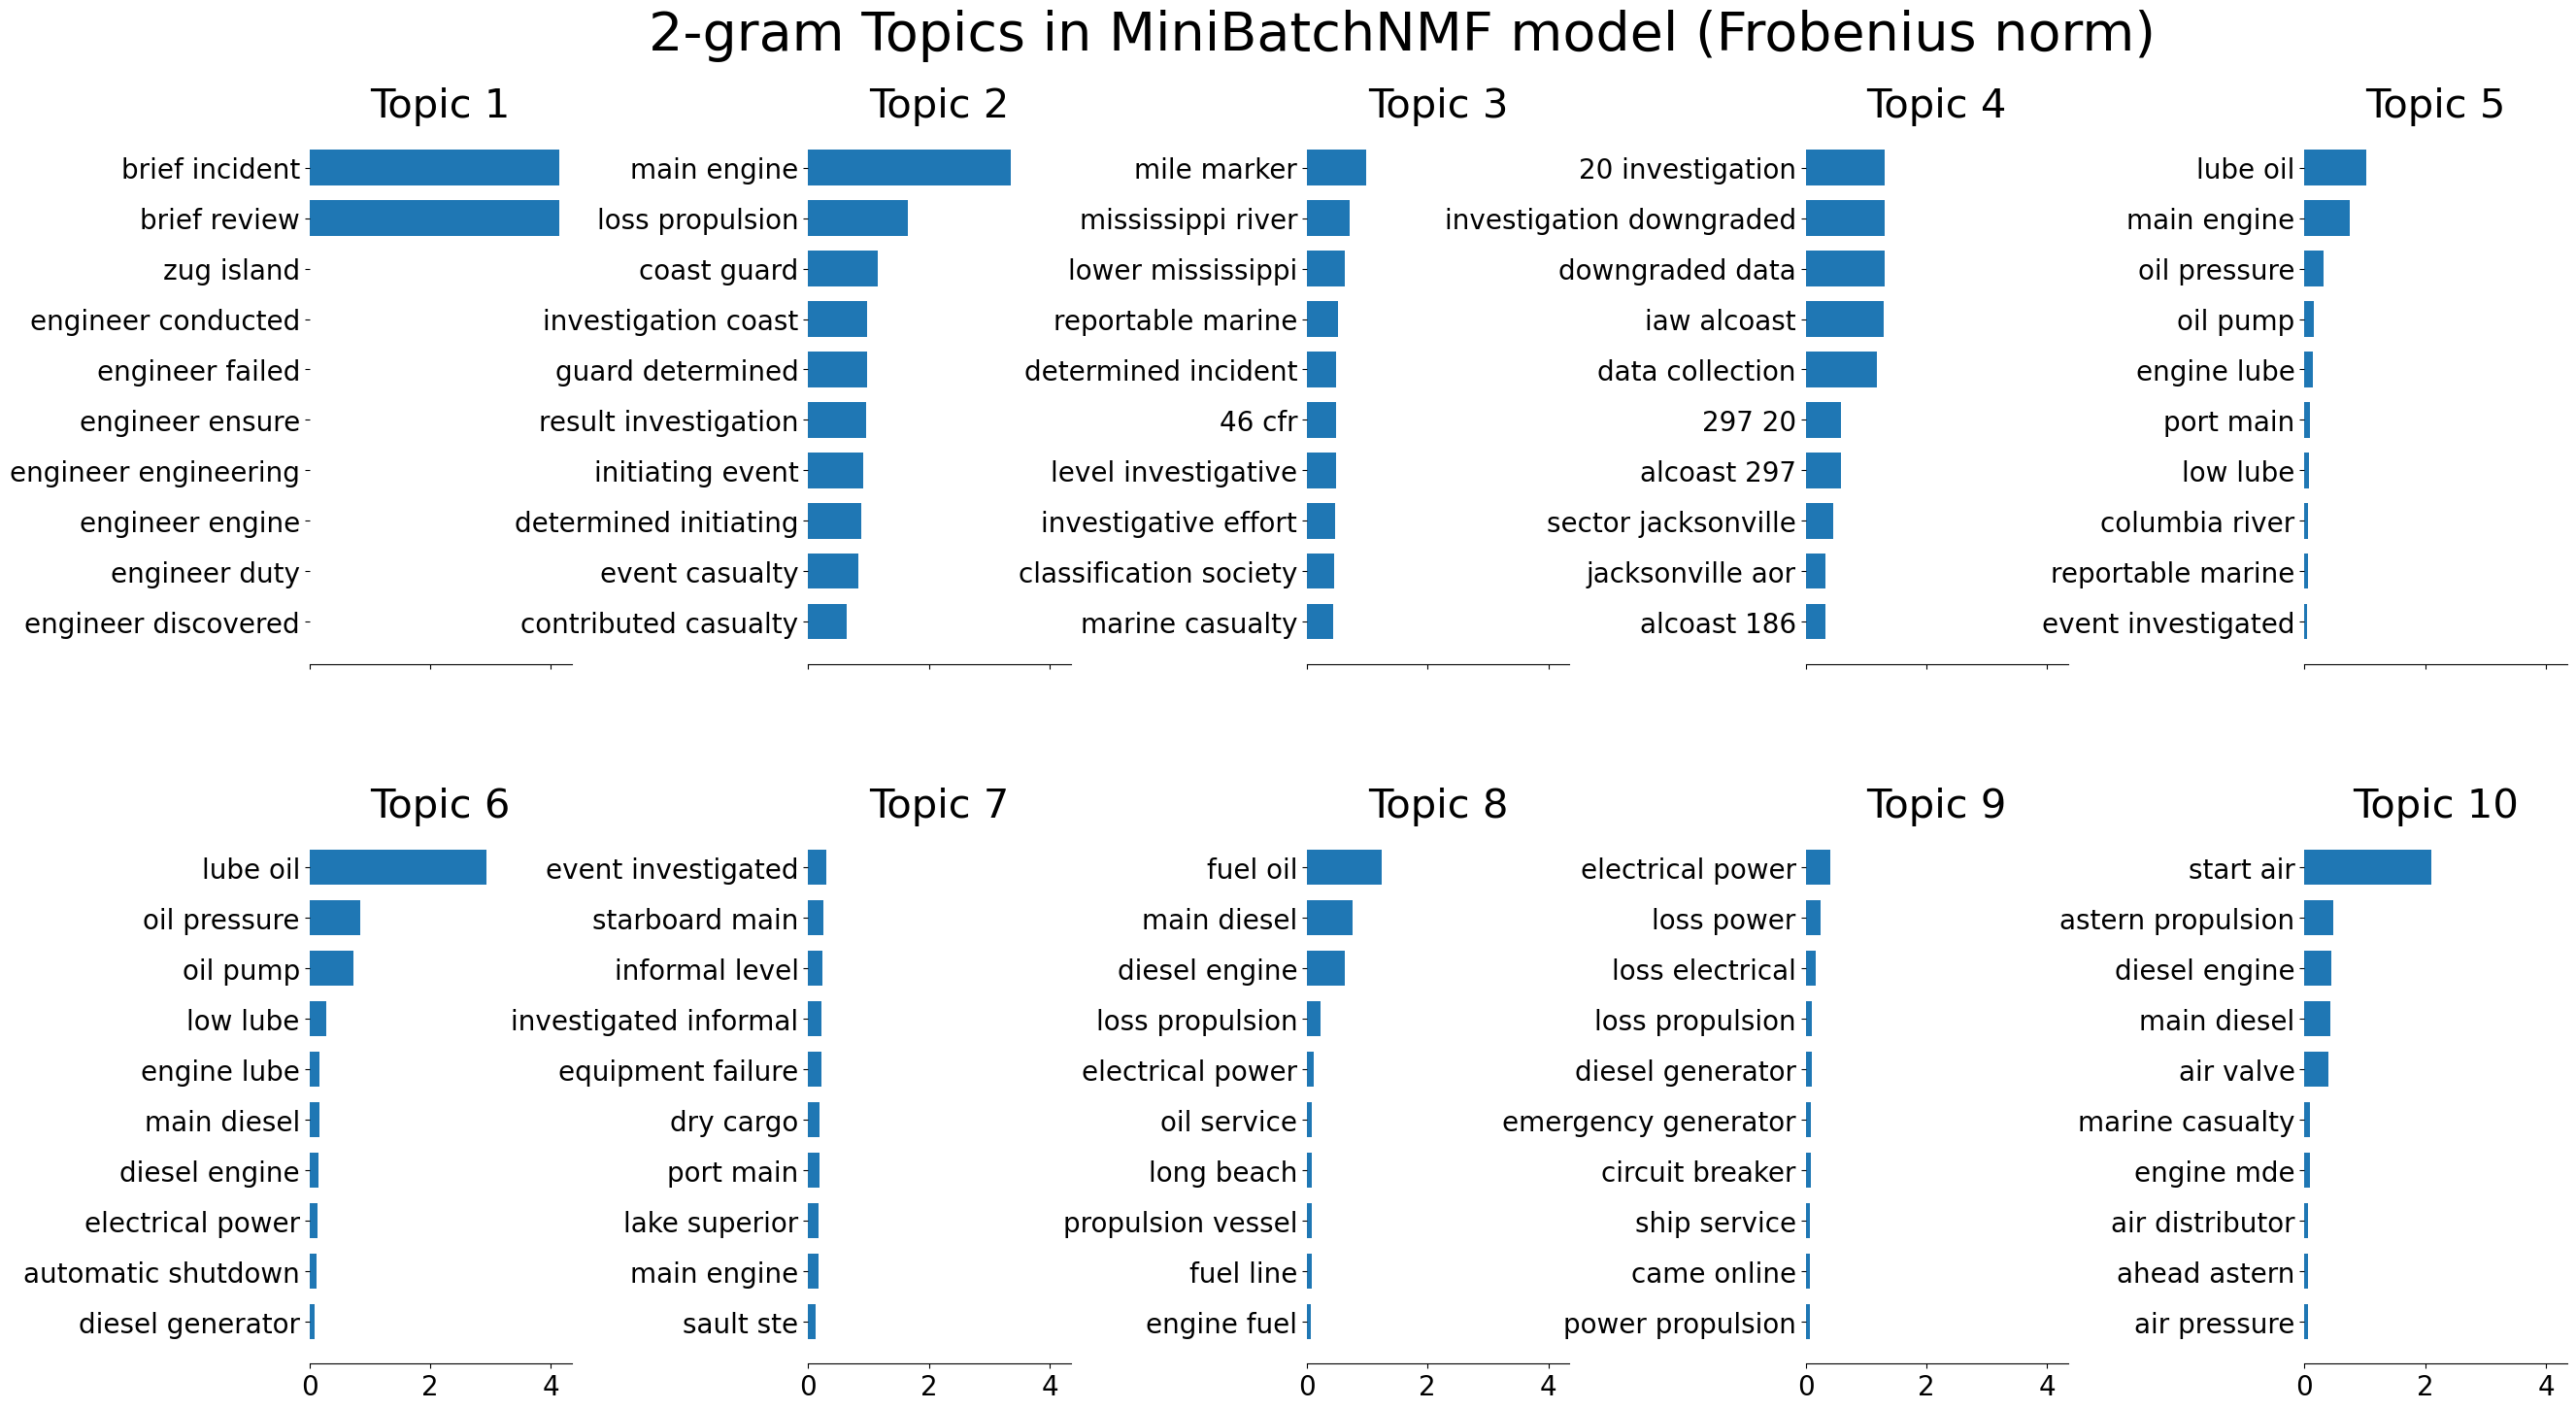

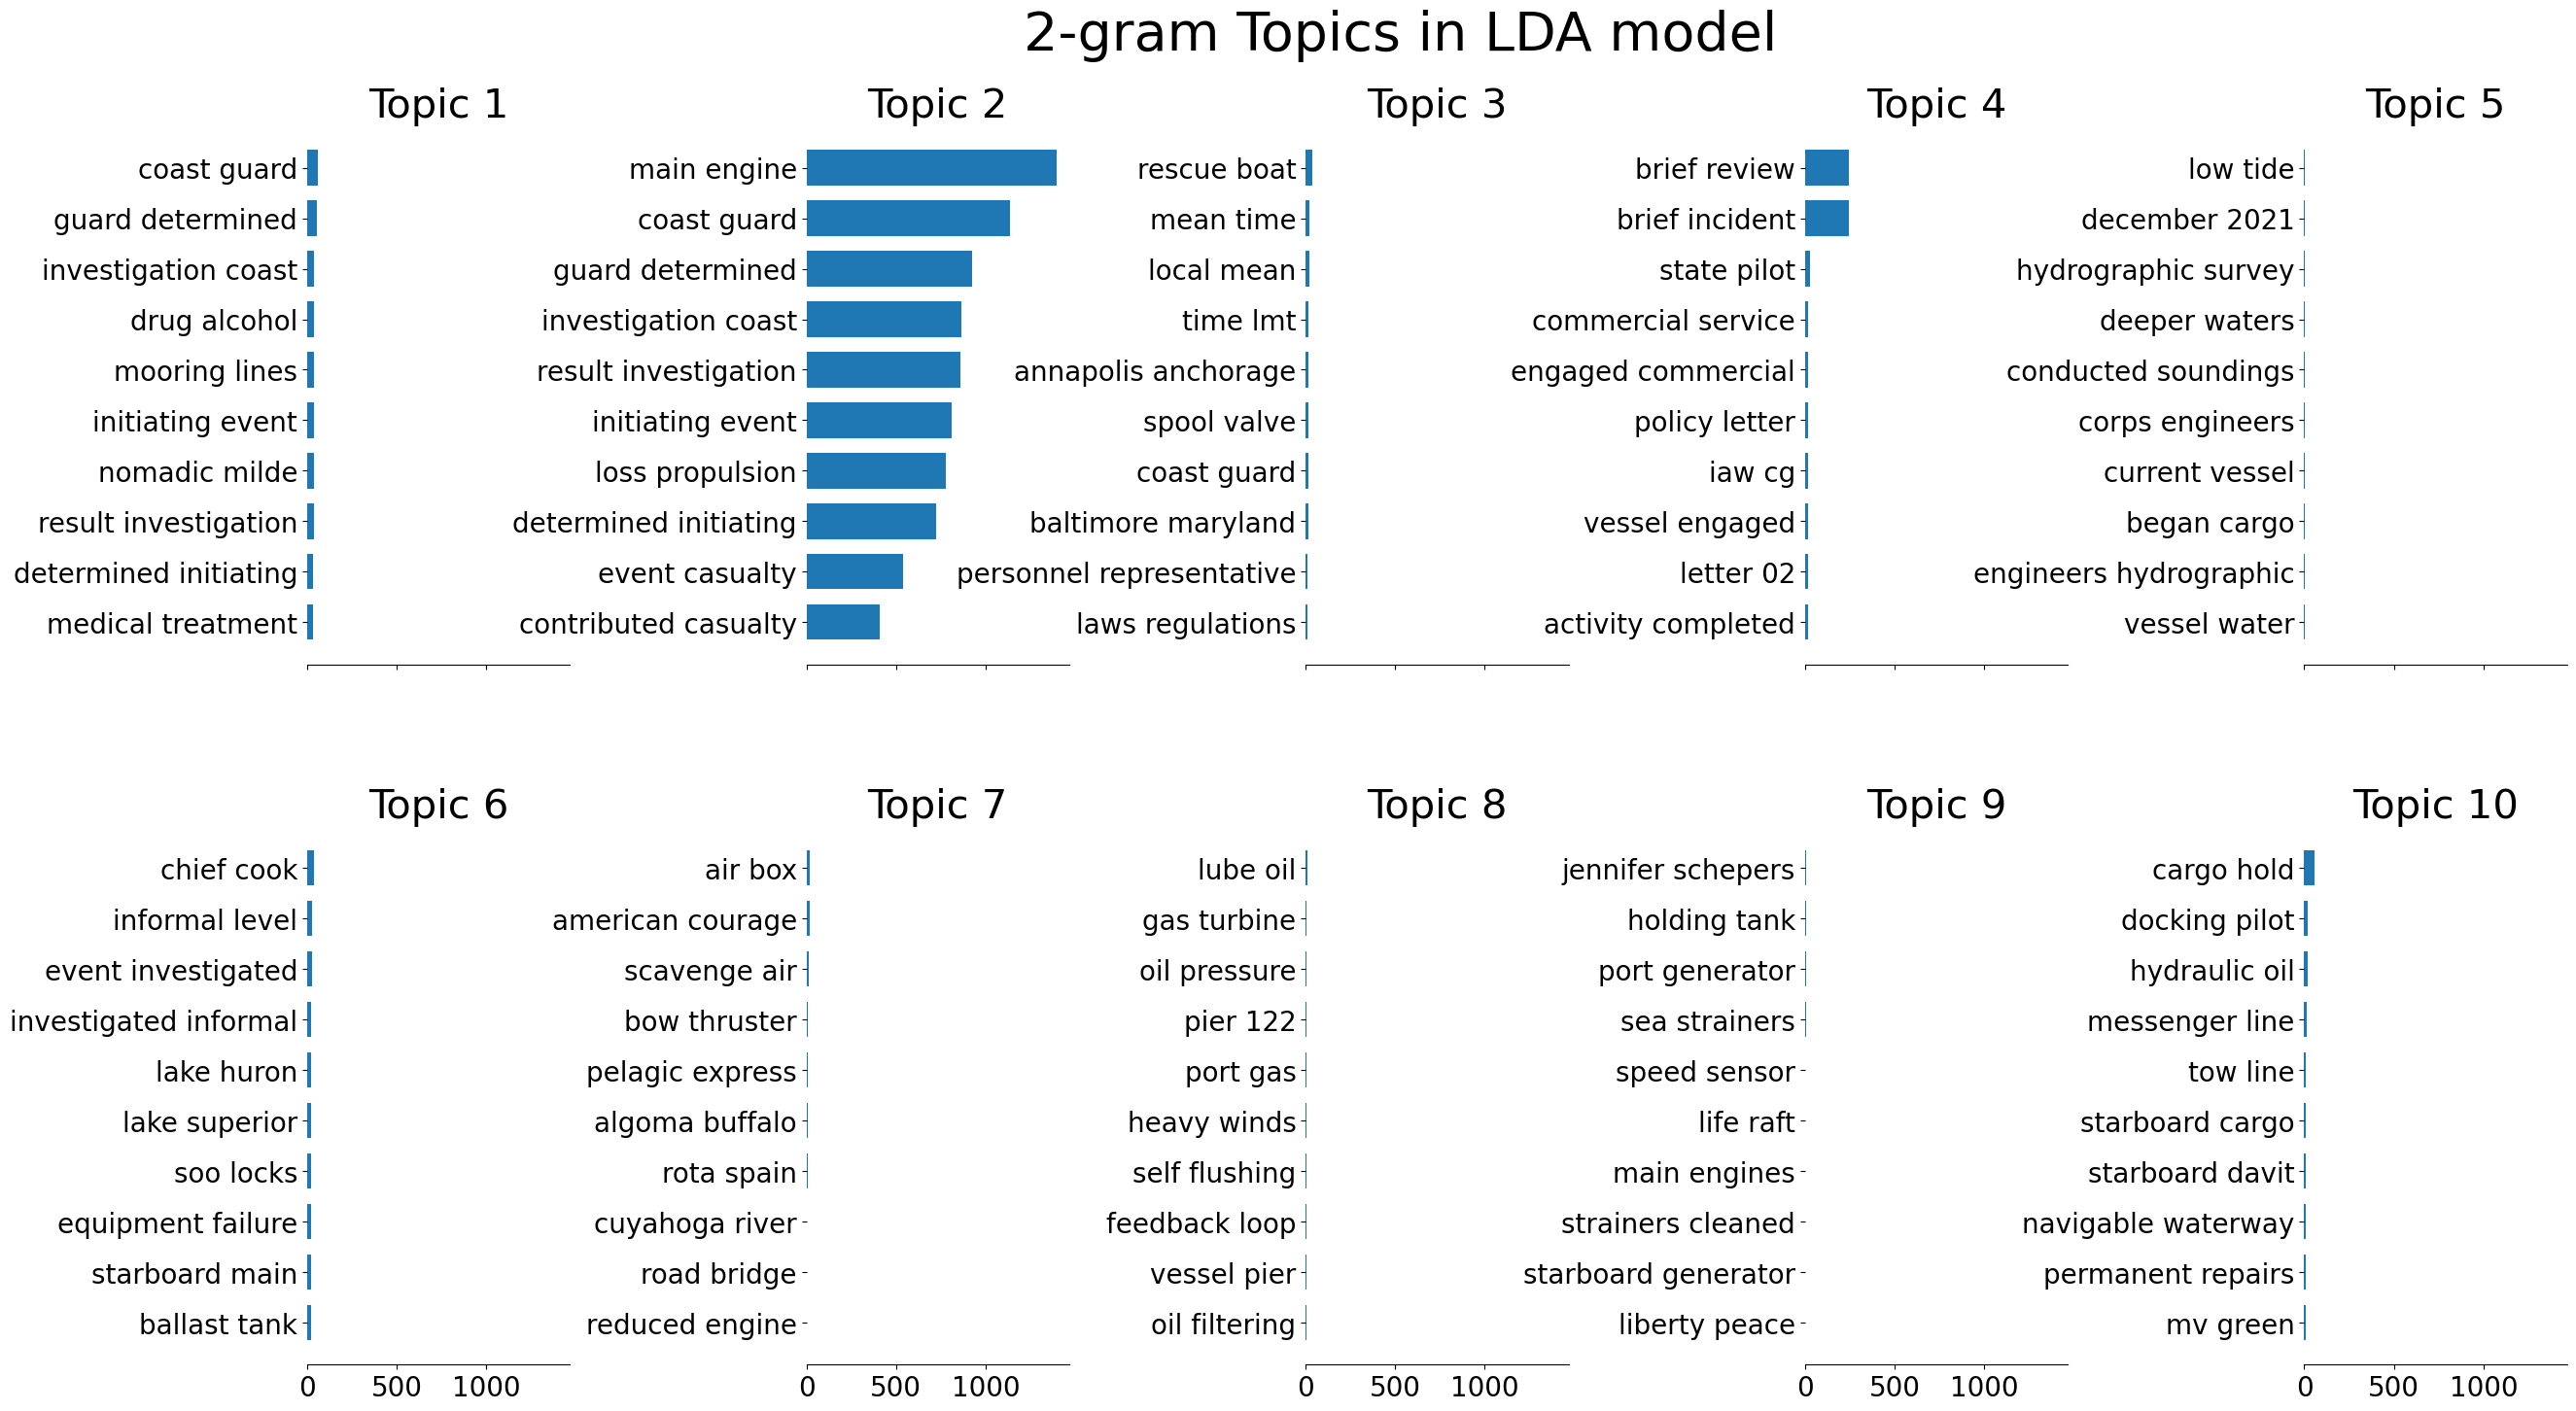

In [17]:
nmf = NMF(n_components=10,
          random_state=1,
          alpha_H=0.00005,
          alpha_W=0.00005, 
          l1_ratio=.5, 
          beta_loss="kullback-leibler",
          solver="mu",
          init="nndsvd").fit(tfid)

tfidf_feature_names = tfid_vectorizer.get_feature_names_out()
plot_top_words(nmf, tfidf_feature_names, 10, "2-gram Topics in NMF model (K-L norm)")

mbnmf = MiniBatchNMF(n_components=10, 
                     random_state=1, 
                     alpha_H=0.00005,
                     alpha_W=0.00005,
                     beta_loss="frobenius", 
                     l1_ratio=.5, 
                     init="nndsvd").fit(tfid)

tfidf_feature_names = tfid_vectorizer.get_feature_names_out()
plot_top_words(mbnmf, tfidf_feature_names, 10, "2-gram Topics in MiniBatchNMF model (Frobenius norm)")

lda = LatentDirichletAllocation(n_components=10,
                                max_iter=5,
                                learning_method="online",
                                learning_offset=50.,
                                random_state=0).fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, 10, "2-gram Topics in LDA model")

In [25]:
train_briefs = briefs[:1400]
test_briefs = briefs[1400:]

In [32]:
# nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
punkt = nltk.tokenize.punkt.PunktSentenceTokenizer("\n".join(train_briefs))
tokenized = punkt.tokenize("\n".join(test_briefs))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/danielgilmore/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [35]:
tokenized

['I. INCIDENT BRIEF\nOn August 28, 2021, the 941-foot freight vessel MAERSK CHICAGO (O.N. 1245544) was underway in the North Atlantic Ocean travelling to Algeciras, Spain.',
 'The vessel’s emergency fire pump failed while the crew was performing a weekly test.',
 'The impeller nut was loose causing the impeller to rub on the pump casing.',
 'On August 5, 2021, the emergency fire pump was overhauled and the crew noticed vibrations during operation.',
 'The pump was still able to achieve operational pressure and the vessel’s classification society did not issue any conditions of class at that time.',
 'When the vessel arrived in Algeciras, Spain, a technician was brought on board and the pump seating had to be completely machined.',
 'The total coast of the repairs were estimated at $2,000.',
 'As a result of its investigation, the Coast Guard has determined that the initiating event for this casualty was the failure of the emergency fire pump, which led to the vessel not being fit for s

In [33]:
for i in tokenized:
    words = nltk.word_tokenize(i)
    tagged = nltk.pos_tag(words)

    print(tagged)

[('I', 'PRP'), ('.', '.'), ('INCIDENT', 'NNP'), ('BRIEF', 'NNP'), ('On', 'IN'), ('August', 'NNP'), ('28', 'CD'), (',', ','), ('2021', 'CD'), (',', ','), ('the', 'DT'), ('941-foot', 'JJ'), ('freight', 'NN'), ('vessel', 'NN'), ('MAERSK', 'NNP'), ('CHICAGO', 'NNP'), ('(', '('), ('O.N', 'NNP'), ('.', '.'), ('1245544', 'CD'), (')', ')'), ('was', 'VBD'), ('underway', 'RB'), ('in', 'IN'), ('the', 'DT'), ('North', 'NNP'), ('Atlantic', 'NNP'), ('Ocean', 'NNP'), ('travelling', 'VBG'), ('to', 'TO'), ('Algeciras', 'NNP'), (',', ','), ('Spain', 'NNP'), ('.', '.')]
[('The', 'DT'), ('vessel', 'NN'), ('’', 'NNP'), ('s', 'NN'), ('emergency', 'NN'), ('fire', 'NN'), ('pump', 'NN'), ('failed', 'VBD'), ('while', 'IN'), ('the', 'DT'), ('crew', 'NN'), ('was', 'VBD'), ('performing', 'VBG'), ('a', 'DT'), ('weekly', 'JJ'), ('test', 'NN'), ('.', '.')]
[('The', 'DT'), ('impeller', 'NN'), ('nut', 'NN'), ('was', 'VBD'), ('loose', 'JJ'), ('causing', 'VBG'), ('the', 'DT'), ('impeller', 'NN'), ('to', 'TO'), ('rub', 'V